# Voynich TF-IDF exploration
Interactive scratchpad for per-page TF-IDF, strong terms, and page similarity. Adjust params below and re-run cells.


In [13]:
# Setup imports and plot style
from collections import Counter
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import tfidf_keyness as tk
plt.style.use("seaborn-v0_8-colorblind")


In [14]:
# Parameters for TF-IDF build and similarity filtering (re-run before rebuild)
# TF-IDF is built only over the pages in the selected Currier slice.
currier = "a"   # "a", "b", or "all"
exclude_hapax = False
cleaned = True
resolver = None  # plug in a resolver mapping/callable if desired (cleaning now enabled)
prob_thresh = 0.2
gap_thresh = 1.5
k_top = 20
min_weight_strong = 0.15
n_sim = 6
sim_keep_threshold = 0.2  # drop pages whose best similarity to others is below this
sim_top_k = -1  # -1/None = use all terms; else keep only top-k TF-IDF terms per doc for similarity
cluster_distance_threshold = 0.8  # linkage distance threshold for cutting dendrogram
cluster_linkage = "average"
n_cluster_terms = 8  # top shared terms reported per cluster


In [15]:
# Rebuild TF-IDF with current params; collect term stats and similarity (optionally top-k terms only)
labels, docs = tk.group_documents(tk.plain_texts, tk.ordered_pages, currier=currier, cleaned=cleaned, resolver=resolver, prob_thresh=prob_thresh, gap_thresh=gap_thresh, exclude_hapax=exclude_hapax)
vectorizer, X, vocab = tk.build_tfidf(docs)

def prune_topk_sparse(X_in, k):
    if k is None or k < 0:
        return X_in
    X_csr = X_in.tocsr()
    rows, cols, data = [], [], []
    for i in range(X_csr.shape[0]):
        start, end = X_csr.indptr[i], X_csr.indptr[i + 1]
        row_cols = X_csr.indices[start:end]
        row_data = X_csr.data[start:end]
        if row_data.size == 0:
            continue
        idx = np.argsort(row_data)[::-1][:k]
        rows.extend([i] * len(idx))
        cols.extend(row_cols[idx])
        data.extend(row_data[idx])
    return coo_matrix((data, (rows, cols)), shape=X_csr.shape).tocsr()

X_use = prune_topk_sparse(X, sim_top_k)
top_terms = tk.top_terms_by_label(labels, X, vocab, k=k_top)
strong_terms = tk.strong_terms(labels, X, vocab, min_weight=min_weight_strong, k=k_top)
sim = tk.similarity_matrix(X_use)
sim_neigh = tk.top_similar(labels, X_use, n=n_sim)
label_to_idx = {lbl: i for i, lbl in enumerate(labels)}
doc_freqs = [Counter(d.split()) for d in docs]
corpus_freq = Counter(tok for d in docs for tok in d.split())
doc_tokens = [len(d.split()) for d in docs]
max_sim_to_other = []
for i in range(sim.shape[0]):
    row = sim[i].copy()
    if row.shape[0] > 1:
        row[i] = 0
    max_sim_to_other.append(row.max(initial=0))
keep = []
for i, lbl in enumerate(labels):
    row = sim[i].copy()
    if row.shape[0] > 1:
        row[i] = 0
    if row.max(initial=0) >= sim_keep_threshold:
        keep.append(i)
keep_labels = [labels[i] for i in keep]
sim_keep = sim[np.ix_(keep, keep)] if keep else np.array([[]])
X_keep = X_use[keep] if keep else None
print(f"docs={len(labels)}, kept={len(keep)}, vocab={len(vocab)}, cleaned={cleaned}, hapax_excluded={exclude_hapax}, currier={currier}, sim_top_k={sim_top_k}")


docs=95, kept=60, vocab=4760, cleaned=True, hapax_excluded=False, currier=a, sim_top_k=-1


In [16]:
# Preview top-k terms for a small sample of documents
sample_labels = labels[:5]

def terms_to_df(label, terms):
    return pd.DataFrame(terms, columns=["term", "tfidf"]).assign(doc=label)

df_top = pd.concat([terms_to_df(lbl, top_terms[lbl]) for lbl in sample_labels], ignore_index=True)
display(df_top)



,term,tfidf,doc
0,dain,0.183254,f1r
1,cthar,0.167887,f1r
2,?,0.153238,f1r
3,chol,0.146587,f1r
4,okan,0.143367,f1r
...,...,...,...
95,sheoldam,0.114915,f3r
96,schey,0.114915,f3r
97,ychtaiin,0.114915,f3r
98,ydas,0.114915,f3r


In [17]:
# List strongest TF-IDF terms with auxiliary stats per doc
strong_rows = []
for lbl, terms in strong_terms.items():
    idx = label_to_idx[lbl]
    doc_counter = doc_freqs[idx]
    doc_top = top_terms.get(lbl, [])
    second = doc_top[1] if len(doc_top) > 1 else (None, None)
    for term, score in terms:
        strong_rows.append({
            "doc": lbl,
            "term": term,
            "tfidf": float(score),
            "freq_doc": doc_counter.get(term, 0),
            "freq_corpus": corpus_freq.get(term, 0),
            "second_term": second[0],
            "second_tfidf": float(second[1]) if second[1] is not None else None,
        })
strong_df = pd.DataFrame(strong_rows).sort_values(["tfidf"], ascending=False)
display(strong_df.head(50))


,doc,term,tfidf,freq_doc,freq_corpus,second_term,second_tfidf
824,f108v,qokeedy,0.480184,28,138,qokeey,0.299942
837,f111v,qokain,0.454122,24,107,chedy,0.270893
580,f25v,daiin,0.412536,11,434,dshey,0.294383
772,f103r,qokeey,0.405138,26,184,shedy,0.320499
23,f2r,dan,0.404608,4,12,saiin,0.183670
621,f32v,daiin,0.397399,11,434,dain,0.181239
45,f3r,cham,0.394253,4,6,damo,0.229830
55,f4r,chaiin,0.381388,4,25,cthol,0.183410
883,f116r,qokain,0.378161,19,107,shey,0.253806
318,f13v,otchy,0.362355,4,25,d,0.234524


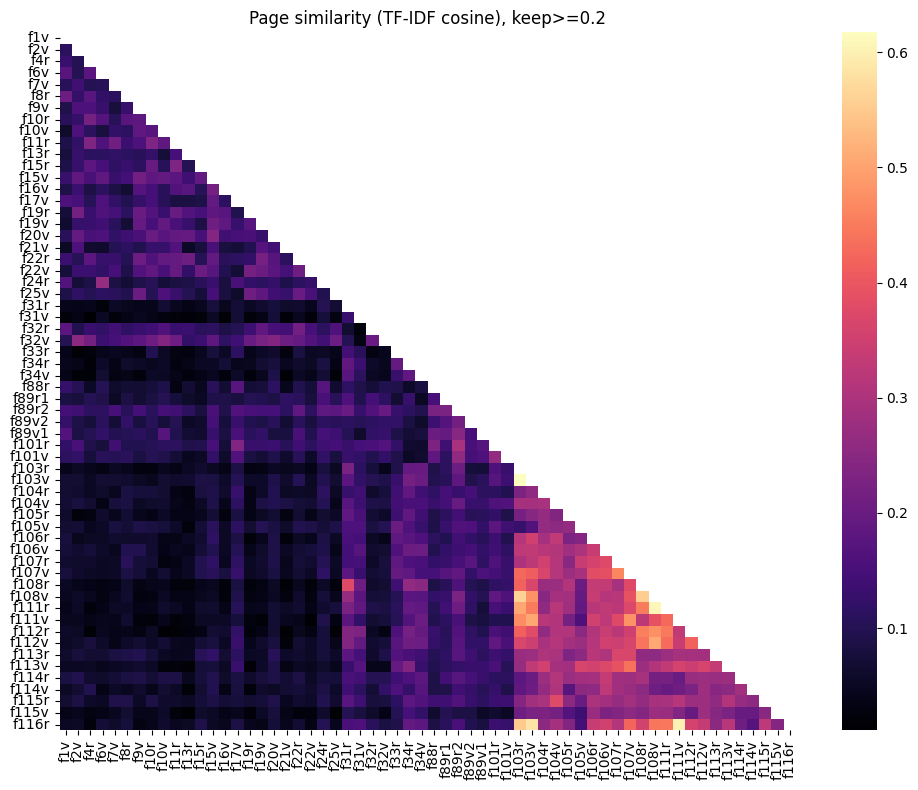

In [18]:
# Plot similarity heatmap for kept pages (max sim >= threshold)
if len(keep_labels) == 0:
    print(f"No pages exceed similarity threshold {sim_keep_threshold}")
else:
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(sim_keep, dtype=bool))
    sns.heatmap(sim_keep, mask=mask, xticklabels=keep_labels, yticklabels=keep_labels, cmap="magma", ax=ax)
    ax.set_title(f"Page similarity (TF-IDF cosine), keep>={sim_keep_threshold}")
    plt.tight_layout()
    plt.show()


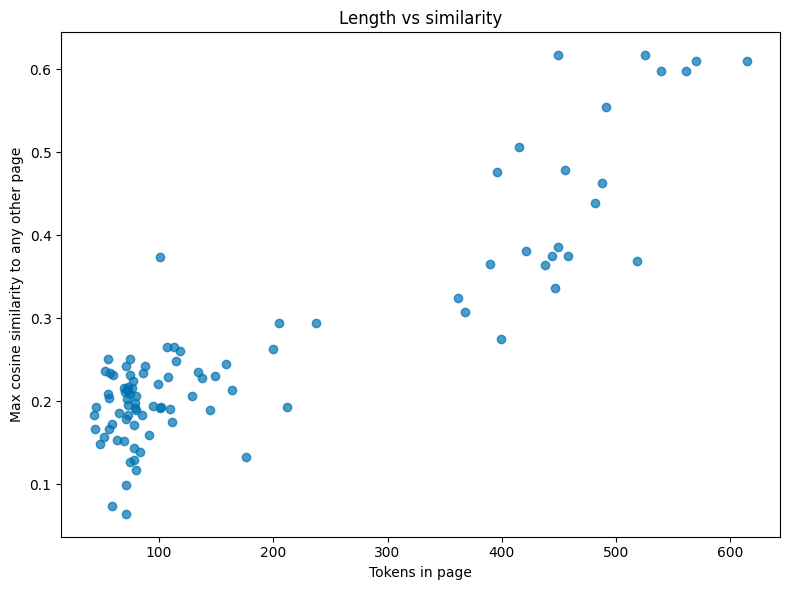

In [19]:
# Scatter: tokens per page vs max similarity to others (after any top-k pruning)
if len(labels) == 0:
    print("No documents to plot")
else:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(doc_tokens, max_sim_to_other, alpha=0.7)
    ax.set_xlabel("Tokens in page")
    ax.set_ylabel("Max cosine similarity to any other page")
    ax.set_title("Length vs similarity")
    plt.tight_layout()
    plt.show()


In [20]:
# Tabulate top-N nearest neighbors per page
neighbors_rows = []
for lbl, neigh in sim_neigh.items():
    for other, score in neigh:
        neighbors_rows.append((lbl, other, score))
neigh_df = pd.DataFrame(neighbors_rows, columns=["doc", "neighbor", "cosine"]).sort_values(["doc", "cosine"], ascending=[True, False])
display(neigh_df.head(50))


,doc,neighbor,cosine
408,f100r,f101r,0.191286
409,f100r,f89r2,0.160639
410,f100r,f17v,0.152079
411,f100r,f88r,0.135423
412,f100r,f20v,0.134719
413,f100r,f8v,0.134371
414,f100v,f89r2,0.159129
415,f100v,f101r,0.125329
416,f100v,f17v,0.124882
417,f100v,f89v1,0.120627


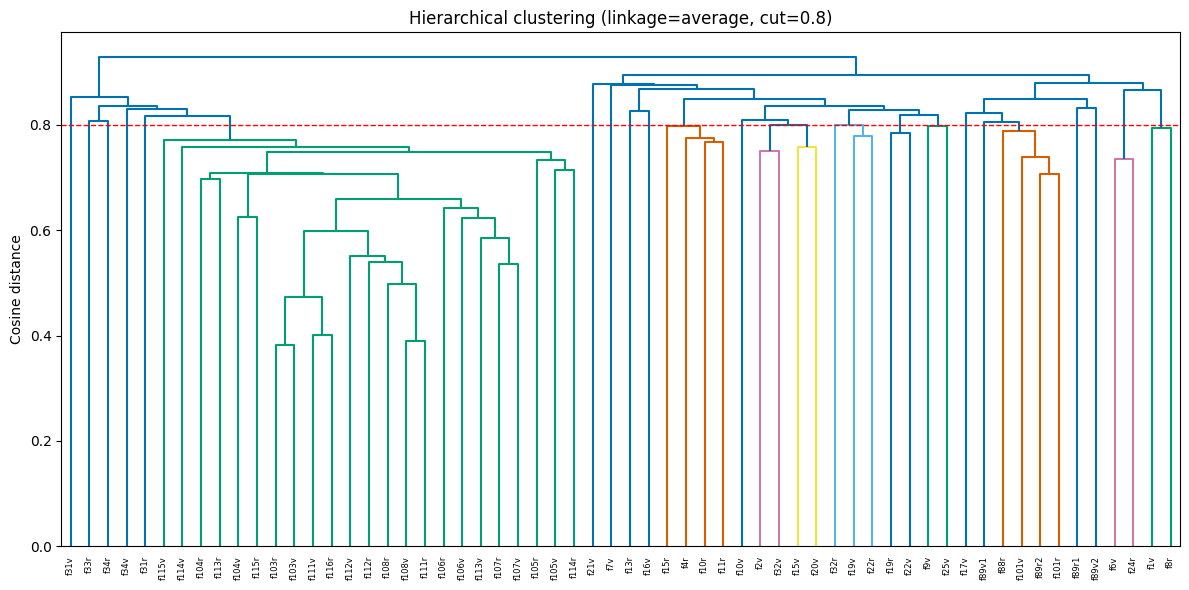

,doc,cluster
27,f33r,1
28,f34r,2
37,f103r,3
38,f103v,3
39,f104r,3
40,f104v,3
41,f105r,3
42,f105v,3
43,f106r,3
44,f106v,3


In [21]:
# Hierarchical clustering on kept pages (cosine distance from pruned matrix)
if len(keep_labels) < 2:
    print("Not enough kept pages for clustering")
else:
    dist_mat = np.clip(1.0 - sim_keep, 0, 2)
    condensed = squareform(dist_mat, checks=False)
    Z = linkage(condensed, method=cluster_linkage)
    fig, ax = plt.subplots(figsize=(12, 6))
    dendrogram(Z, labels=keep_labels, leaf_rotation=90, ax=ax, color_threshold=cluster_distance_threshold)
    ax.axhline(cluster_distance_threshold, color="red", linestyle="--", linewidth=1)
    ax.set_ylabel("Cosine distance")
    ax.set_title(f"Hierarchical clustering (linkage={cluster_linkage}, cut={cluster_distance_threshold})")
    plt.tight_layout()
    plt.show()
    clusters = fcluster(Z, t=cluster_distance_threshold, criterion="distance")
    cluster_df = pd.DataFrame({"doc": keep_labels, "cluster": clusters})
    display(cluster_df.sort_values(["cluster", "doc"]))


In [22]:
# Summarize clusters: page ranges, shared terms, separation metrics
if len(keep_labels) == 0:
    print("No kept pages to summarize")
else:
    if len(keep_labels) == 1:
        clusters = np.array([1])
    cluster_df = pd.DataFrame({"doc": keep_labels, "cluster": clusters})
    order_index = {pid: i for i, pid in enumerate(tk.ordered_pages)}

    def compress_ranges(docs):
        idxs = [order_index.get(d) for d in docs if d in order_index]
        other = [d for d in docs if d not in order_index]
        idxs = sorted([i for i in idxs if i is not None])
        ranges = []
        i = 0
        while i < len(idxs):
            start = idxs[i]
            j = i
            while j + 1 < len(idxs) and idxs[j + 1] == idxs[j] + 1:
                j += 1
            if start == idxs[j]:
                ranges.append(tk.ordered_pages[start])
            else:
                ranges.append(f"{tk.ordered_pages[start]}-{tk.ordered_pages[idxs[j]]}")
            i = j + 1
        ranges.extend(other)
        return ", ".join(ranges)

    rows = []
    Xk = X_keep
    for cid, sub in cluster_df.groupby("cluster"):
        docs_in = list(sub["doc"])
        idxs = [keep_labels.index(d) for d in docs_in]
        sims = sim_keep[np.ix_(idxs, idxs)]
        if sims.size:
            np.fill_diagonal(sims, np.nan)
            intra_vals = sims[~np.isnan(sims)]
            intra_mean = float(intra_vals.mean()) if intra_vals.size else 0.0
            intra_max = float(np.nanmax(sims)) if np.isfinite(sims).any() else 0.0
        else:
            intra_mean = intra_max = 0.0
        outside = [i for i in range(sim_keep.shape[0]) if i not in idxs]
        if outside:
            cross = sim_keep[np.ix_(idxs, outside)]
            inter_mean = float(cross.mean()) if cross.size else 0.0
        else:
            inter_mean = 0.0
        # shared terms: weighted by cluster mean and lift vs rest
        cluster_vec = np.asarray(Xk[idxs].mean(axis=0)).ravel()
        if outside:
            rest_vec = np.asarray(Xk[outside].mean(axis=0)).ravel()
        else:
            rest_vec = np.zeros_like(cluster_vec)
        lift = (cluster_vec + 1e-9) / (rest_vec + 1e-9)
        score = cluster_vec * lift
        top_idx = np.argsort(score)[::-1][:n_cluster_terms]
        top_terms = [(vectorizer.get_feature_names_out()[j], float(cluster_vec[j]), float(lift[j])) for j in top_idx if cluster_vec[j] > 0]
        rows.append({
            "cluster": cid,
            "size": len(docs_in),
            "pages": compress_ranges(docs_in),
            "intra_mean": intra_mean,
            "intra_max": intra_max,
            "inter_mean": inter_mean,
            "top_terms": top_terms,
        })

    cluster_summary = pd.DataFrame(rows).sort_values(["size"], ascending=False)
    display(cluster_summary)



,cluster,size,pages,intra_mean,intra_max,inter_mean,top_terms
2,3,23,f103r-f116r,0.309016,0.617154,0.086737,"[(lchedy, 0.05778477802749014, 57784779.027490..."
8,9,4,"f4r, f10r, f11r, f15r",0.215537,0.233705,0.088320,"[(tydy, 0.07697410926123403, 76974110.26123403..."
17,18,4,"f88r, f89r2, f101r-f101v",0.242237,0.293924,0.121943,"[(qoekol, 0.0513783250831833, 51378326.0831832..."
12,13,3,"f19v, f22r, f32r",0.207443,0.221152,0.101041,"[(choddal, 0.05562215130285027, 55622152.30285..."
10,11,2,"f15v, f20v",0.242702,0.242702,0.116909,"[(orshy, 0.08582853776972926, 85828538.7697292..."
23,24,2,"f1v, f8r",0.206353,0.206353,0.087361,"[(otoaiin, 0.07533870589765303, 75338706.89765..."
13,14,2,"f19r, f22v",0.216737,0.216737,0.092020,"[(chordy, 0.14331452037361128, 143314521.37361..."
14,15,2,"f9v, f25v",0.201931,0.201931,0.092080,"[(qochol, 0.15306358427829606, 153063585.27829..."
22,23,2,"f6v, f24r",0.265749,0.265749,0.094233,"[(cthal, 0.10608264966204069, 106082650.662040..."
9,10,2,"f2v, f32v",0.250960,0.250960,0.106069,"[(chokoishe, 0.10011823273564971, 100118233.73..."


In [23]:
# Detailed per-cluster breakdown with top shared terms
if len(keep_labels) == 0:
    print("No kept pages to detail")
else:
    if len(keep_labels) == 1:
        clusters = np.array([1])
    cluster_df = pd.DataFrame({"doc": keep_labels, "cluster": clusters})
    order_index = {pid: i for i, pid in enumerate(tk.ordered_pages)}

    def compress_ranges(docs):
        idxs = [order_index.get(d) for d in docs if d in order_index]
        other = [d for d in docs if d not in order_index]
        idxs = sorted([i for i in idxs if i is not None])
        ranges = []
        i = 0
        while i < len(idxs):
            start = idxs[i]
            j = i
            while j + 1 < len(idxs) and idxs[j + 1] == idxs[j] + 1:
                j += 1
            if start == idxs[j]:
                ranges.append(tk.ordered_pages[start])
            else:
                ranges.append(f"{tk.ordered_pages[start]}-{tk.ordered_pages[idxs[j]]}")
            i = j + 1
        ranges.extend(other)
        return ", ".join(ranges)

    for cid, sub in cluster_df.groupby("cluster"):
        docs_in = list(sub["doc"])
        if len(docs_in) <= 1: continue
        idxs = [keep_labels.index(d) for d in docs_in]
        outside = [i for i in range(sim_keep.shape[0]) if i not in idxs]
        cluster_vec = np.asarray(X_keep[idxs].mean(axis=0)).ravel()
        if outside:
            rest_vec = np.asarray(X_keep[outside].mean(axis=0)).ravel()
        else:
            rest_vec = np.zeros_like(cluster_vec)
        lift = (cluster_vec + 1e-9) / (rest_vec + 1e-9)
        score = cluster_vec * lift
        top_idx = np.argsort(score)[::-1][:n_cluster_terms]
        top_terms = [(vectorizer.get_feature_names_out()[j], float(cluster_vec[j]), float(lift[j])) for j in top_idx if cluster_vec[j] > 0]
        print(f"Cluster {cid} (n={len(docs_in)}): {compress_ranges(docs_in)}")
        print("  Top shared terms (score = mean_tf_idf * lift vs rest):")
        for term, mean_w, lift_w in top_terms:
            print(f"    {term:15s} mean_tfidf={mean_w:.4f} lift={lift_w:.2f}")
        # indicator: intra vs inter
        sims = sim_keep[np.ix_(idxs, idxs)]
        if sims.size:
            np.fill_diagonal(sims, np.nan)
            intra_vals = sims[~np.isnan(sims)]
            intra_mean = float(intra_vals.mean()) if intra_vals.size else 0.0
        else:
            intra_mean = 0.0
        if outside:
            cross = sim_keep[np.ix_(idxs, outside)]
            inter_mean = float(cross.mean()) if cross.size else 0.0
        else:
            inter_mean = 0.0
        print(f"  Intra-mean={intra_mean:.3f}, Inter-mean={inter_mean:.3f}\n")


Cluster 3 (n=23): f103r-f116r
  Top shared terms (score = mean_tf_idf * lift vs rest):
    lchedy          mean_tfidf=0.0578 lift=57784779.03
    lkaiin          mean_tfidf=0.0487 lift=48671416.15
    qotain          mean_tfidf=0.0407 lift=40667984.96
    qokchedy        mean_tfidf=0.0388 lift=38822914.90
    lkeey           mean_tfidf=0.0379 lift=37943728.13
    lkain           mean_tfidf=0.0355 lift=35458382.66
    lkeedy          mean_tfidf=0.0345 lift=34469715.81
    opchedy         mean_tfidf=0.0306 lift=30555522.81
  Intra-mean=0.309, Inter-mean=0.087

Cluster 9 (n=4): f4r, f10r, f11r, f15r
  Top shared terms (score = mean_tf_idf * lift vs rest):
    tydy            mean_tfidf=0.0770 lift=76974110.26
    chodl           mean_tfidf=0.0456 lift=45593060.89
    ded             mean_tfidf=0.0456 lift=45593060.89
    ds              mean_tfidf=0.0456 lift=45593060.89
    ytchoky         mean_tfidf=0.0456 lift=45593060.89
    schoal          mean_tfidf=0.0456 lift=45593060.89
    shoyt

In [24]:
# Least-informative words: high document frequency and low TF-IDF variance
if X.shape[0] == 0:
    print("No documents loaded")
else:
    df = (X > 0).sum(axis=0).A1 / X.shape[0]
    mean = np.asarray(X.mean(axis=0)).ravel()
    var = np.asarray(X.power(2).mean(axis=0)).ravel() - mean ** 2
    vocab_arr = vectorizer.get_feature_names_out()
    df_thresh = 0.5  # keep terms appearing in at least 50% of docs
    top_n_bland = 50
    idx = np.where(df >= df_thresh)[0]
    sorted_idx = idx[np.argsort(var[idx])]
    rows = []
    for j in sorted_idx[:top_n_bland]:
        rows.append({
            "term": vocab_arr[j],
            "df_frac": float(df[j]),
            "tfidf_mean": float(mean[j]),
            "tfidf_var": float(var[j]),
        })
    bland_df = pd.DataFrame(rows)
    display(bland_df)



,term,df_frac,tfidf_mean,tfidf_var
0,or,0.610526,0.038219,0.001711
1,ol,0.631579,0.042655,0.001735
2,dar,0.568421,0.034708,0.001757
3,chey,0.526316,0.037501,0.002126
4,shol,0.505263,0.034417,0.002152
5,s,0.621053,0.044376,0.002981
6,chor,0.694737,0.050697,0.003125
7,chol,0.800000,0.063781,0.003740
8,dy,0.515789,0.041288,0.004091
9,daiin,0.936842,0.113746,0.008255
